In [1]:
!pip install torch torchvision torchaudio --quiet

import os
import random
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models

from google.colab import drive


In [2]:

drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/DL_Project_Dataset"

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Mounted at /content/drive
Using device: cuda


In [ ]:
CLASS_NAMES = [
    "Ford_F-150_(thirteenth_generation)",
    "Ford_Mustang_VI",
    "Renault_Kangoo_I",
    "Renault_Twizy_Z.E.",
    "Toyota_Land_Cruiser_(J40)",
    "Toyota_Supra_(A80)",
    "Volkswagen_Passat_B6",
    "Volkswagen_Type_1",
]

print("Expected folders:")
for name in CLASS_NAMES:
    print(" -", name)


Beklenen klasörler:
 - Ford_F-150_(thirteenth_generation)
 - Ford_Mustang_VI
 - Renault_Kangoo_I
 - Renault_Twizy_Z.E.
 - Toyota_Land_Cruiser_(J40)
 - Toyota_Supra_(A80)
 - Volkswagen_Passat_B6
 - Volkswagen_Type_1


In [ ]:
tmp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=DATA_ROOT, transform=tmp_transform)
print("ImageFolder classes:", full_dataset.classes)

for idx, cls_name in enumerate(full_dataset.classes):
    print(idx, "->", cls_name)

ImageFolder classes: ['Ford_F-150_(thirteenth_generation)', 'Ford_Mustang_VI', 'Renault_Kangoo_I', 'Renault_Twizy_Z.E', 'Toyota_Land_Cruiser_(J40)', 'Toyota_Supra_(A80)', 'Volkswagen_Passat_B6', 'Volkswagen_Type_1']
0 -> Ford_F-150_(thirteenth_generation)
1 -> Ford_Mustang_VI
2 -> Renault_Kangoo_I
3 -> Renault_Twizy_Z.E
4 -> Toyota_Land_Cruiser_(J40)
5 -> Toyota_Supra_(A80)
6 -> Volkswagen_Passat_B6
7 -> Volkswagen_Type_1


In [ ]:
brand_id_for_class = {
    # class_index : brand_index
    0: 0,  # Ford_F-150_(thirteenth_generation)   -> Ford
    1: 0,  # Ford_Mustang_VI                      -> Ford
    2: 1,  # Renault_Kangoo_I                     -> Renault
    3: 1,  # Renault_Twizy_Z.E.                   -> Renault
    4: 2,  # Toyota_Land_Cruiser_(J40)            -> Toyota
    5: 2,  # Toyota_Supra_(A80)                   -> Toyota
    6: 3,  # Volkswagen_Passat_B6                 -> VW
    7: 3,  # Volkswagen_Type_1                    -> VW
}

brand_names = ["Ford", "Renault", "Toyota", "Volkswagen"]

classes_for_brand = {
    0: [0, 1],  # Ford
    1: [2, 3],  # Renault
    2: [4, 5],  # Toyota
    3: [6, 7],  # VW
}

print("Brand mapping:")
for cls_idx, br_idx in brand_id_for_class.items():
    print(f"Class {cls_idx} ({full_dataset.classes[cls_idx]}) -> Brand {br_idx} ({brand_names[br_idx]})")


class BrandDataset(Dataset):
    def __init__(self, base_dataset, brand_id_for_class):
        self.base_dataset = base_dataset
        self.brand_id_for_class = brand_id_for_class

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, original_class = self.base_dataset[idx]
        brand_label = self.brand_id_for_class[original_class]
        return img, brand_label


class SubsetForBrandModels(Dataset):
    def __init__(self, base_dataset, allowed_class_indices):
        self.base_dataset = base_dataset
        self.allowed = allowed_class_indices

        self.indices = []
        self.new_labels = []

        class_to_new = {cls_idx: i for i, cls_idx in enumerate(self.allowed)}

        for i in range(len(base_dataset)):
            _, original_class = base_dataset[i]
            if original_class in self.allowed:
                self.indices.append(i)
                self.new_labels.append(class_to_new[original_class])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        base_idx = self.indices[idx]
        img, _ = self.base_dataset[base_idx]
        label = self.new_labels[idx]
        return img, label


Brand mapping:
Class 0 (Ford_F-150_(thirteenth_generation)) -> Brand 0 (Ford)
Class 1 (Ford_Mustang_VI) -> Brand 0 (Ford)
Class 2 (Renault_Kangoo_I) -> Brand 1 (Renault)
Class 3 (Renault_Twizy_Z.E) -> Brand 1 (Renault)
Class 4 (Toyota_Land_Cruiser_(J40)) -> Brand 2 (Toyota)
Class 5 (Toyota_Supra_(A80)) -> Brand 2 (Toyota)
Class 6 (Volkswagen_Passat_B6) -> Brand 3 (Volkswagen)
Class 7 (Volkswagen_Type_1) -> Brand 3 (Volkswagen)


In [ ]:
from sklearn.model_selection import train_test_split

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


base_dataset_train = datasets.ImageFolder(root=DATA_ROOT, transform=train_transform)
base_dataset_val   = datasets.ImageFolder(root=DATA_ROOT, transform=val_transform)


indices = list(range(len(base_dataset_train)))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
    stratify=[full_dataset[i][1] for i in indices]
)

print("Train size:", len(train_idx), "Val size:", len(val_idx))

/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Train size: 1161 Val size: 291


In [ ]:
BATCH_SIZE = 32

brand_dataset_train_full = BrandDataset(base_dataset_train, brand_id_for_class)
brand_dataset_val_full   = BrandDataset(base_dataset_val,   brand_id_for_class)

brand_train_ds = Subset(brand_dataset_train_full, train_idx)
brand_val_ds   = Subset(brand_dataset_val_full,   val_idx)

brand_train_loader = DataLoader(brand_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
brand_val_loader   = DataLoader(brand_val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Brand train batches:", len(brand_train_loader))
print("Brand val batches:", len(brand_val_loader))


Brand train batches: 37
Brand val batches: 10


In [ ]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        out = self.relu(out)
        return out


class CustomResNet18(nn.Module):

    def __init__(self, num_classes=4):
        super(CustomResNet18, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64,  2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(p=0.3)

        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        self._init_weights()

    def _make_layer(self, block, out_channels, blocks, stride=1):

        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0.)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)   #64
        x = self.layer2(x)   #128
        x = self.layer3(x)   #256
        x = self.layer4(x)   #512

        x = self.avgpool(x)
        x = torch.flatten(x, 1)  #(B, 512)

        x = self.dropout(x)
        x = self.fc(x)
        return x


In [ ]:
import copy
import math

def create_resnet(num_classes):

    model = CustomResNet18(num_classes=num_classes)
    return model.to(device)


def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * images.size(0)
        running_correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * images.size(0)
            running_correct += (preds == labels).sum().item()
            total += images.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-3):

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc     = evaluate(model, val_loader, criterion)
        scheduler.step()

        print(f"Epoch {epoch+1:02d}/{num_epochs:02d} "
              f"- train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
              f"- val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print("Best val acc:", best_val_acc)
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
NUM_BRANDS = 4

brand_model = create_resnet(num_classes=NUM_BRANDS)
print(brand_model.fc)

brand_model = train_model(
    brand_model,
    brand_train_loader,
    brand_val_loader,
    num_epochs=30,
    lr=3e-4
)

os.makedirs("/content/models", exist_ok=True)
torch.save(brand_model.state_dict(), "/content/models/brand_classifier_resnet18.pth")
print("Brand model saved.")


Linear(in_features=512, out_features=4, bias=True)


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 01/30 - train loss: 1.3593, acc: 0.3454 - val loss: 1.5531, acc: 0.3608


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 02/30 - train loss: 1.2331, acc: 0.4625 - val loss: 1.2869, acc: 0.4399


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 03/30 - train loss: 1.2299, acc: 0.4875 - val loss: 2.1743, acc: 0.3196


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 04/30 - train loss: 1.0907, acc: 0.5306 - val loss: 2.6400, acc: 0.3299


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 05/30 - train loss: 1.0181, acc: 0.5874 - val loss: 1.0908, acc: 0.5086


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 06/30 - train loss: 0.9871, acc: 0.5995 - val loss: 1.1042, acc: 0.5498


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 07/30 - train loss: 0.9038, acc: 0.6382 - val loss: 0.9744, acc: 0.6220


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 08/30 - train loss: 0.8211, acc: 0.6830 - val loss: 0.8839, acc: 0.5979


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 09/30 - train loss: 0.7819, acc: 0.6968 - val loss: 1.0993, acc: 0.5498


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 10/30 - train loss: 0.7471, acc: 0.7089 - val loss: 1.1499, acc: 0.5911


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 11/30 - train loss: 0.6433, acc: 0.7485 - val loss: 1.8104, acc: 0.4914


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 12/30 - train loss: 0.6157, acc: 0.7649 - val loss: 0.9249, acc: 0.6701


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 13/30 - train loss: 0.5758, acc: 0.7967 - val loss: 1.0058, acc: 0.6220


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 14/30 - train loss: 0.4812, acc: 0.8157 - val loss: 1.1454, acc: 0.6289


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 15/30 - train loss: 0.4441, acc: 0.8312 - val loss: 1.0482, acc: 0.6186


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 16/30 - train loss: 0.3942, acc: 0.8501 - val loss: 0.8054, acc: 0.7045


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 17/30 - train loss: 0.3844, acc: 0.8553 - val loss: 0.9048, acc: 0.6838


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 18/30 - train loss: 0.3281, acc: 0.8820 - val loss: 0.6986, acc: 0.7663


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 19/30 - train loss: 0.3129, acc: 0.8898 - val loss: 0.7075, acc: 0.7423


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 20/30 - train loss: 0.2677, acc: 0.9104 - val loss: 0.8912, acc: 0.7113


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 21/30 - train loss: 0.2298, acc: 0.9285 - val loss: 0.6308, acc: 0.7732


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 22/30 - train loss: 0.2074, acc: 0.9294 - val loss: 0.7022, acc: 0.7560


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 23/30 - train loss: 0.1650, acc: 0.9535 - val loss: 0.5946, acc: 0.8041


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 24/30 - train loss: 0.1748, acc: 0.9449 - val loss: 0.7092, acc: 0.7560


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 25/30 - train loss: 0.1573, acc: 0.9475 - val loss: 0.5929, acc: 0.8007


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 26/30 - train loss: 0.1525, acc: 0.9526 - val loss: 0.5820, acc: 0.7938


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 27/30 - train loss: 0.1337, acc: 0.9655 - val loss: 0.5900, acc: 0.7801


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 28/30 - train loss: 0.1182, acc: 0.9733 - val loss: 0.5722, acc: 0.8007


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 29/30 - train loss: 0.1268, acc: 0.9655 - val loss: 0.5619, acc: 0.7973


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


Epoch 30/30 - train loss: 0.1217, acc: 0.9673 - val loss: 0.5686, acc: 0.7904
Best val acc: 0.8041237113402062
Brand model saved.


/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


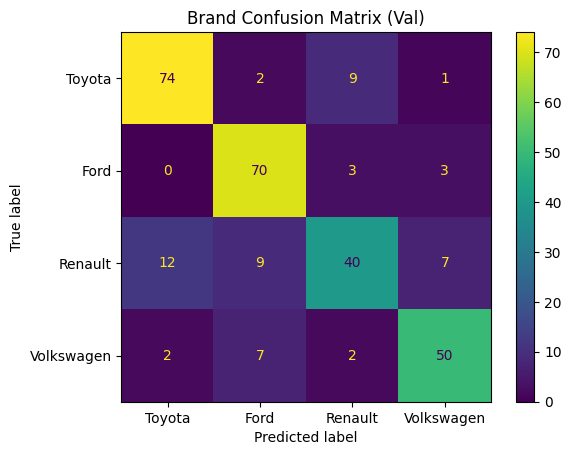

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


BRANDS = ["Toyota", "Ford", "Renault", "Volkswagen"]

@torch.no_grad()
def collect_preds(model, loader):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        p = logits.argmax(dim=1).cpu().numpy()
        all_p.extend(p.tolist())
        all_y.extend(y.numpy().tolist())
    return np.array(all_y), np.array(all_p)


y_true, y_pred = collect_preds(brand_model, brand_val_loader)
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(cm, display_labels=BRANDS)
disp.plot(values_format="d")
plt.title("Brand Confusion Matrix (Val)")
plt.show()

In [ ]:
brand_model_dataloaders = {}

for brand_idx, class_indices in classes_for_brand.items():

    ds_train_brand = SubsetForBrandModels(base_dataset_train, class_indices)
    ds_val_brand   = SubsetForBrandModels(base_dataset_val,   class_indices)

    train_loader = DataLoader(ds_train_brand, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader   = DataLoader(ds_val_brand,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    brand_model_dataloaders[brand_idx] = (train_loader, val_loader)
    print(f"Brand {brand_idx} ({brand_names[brand_idx]}): "
          f"train size = {len(ds_train_brand)}, val size = {len(ds_val_brand)}")


/usr/local/lib/python3.12/dist-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90594944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Brand 0 (Ford): train size = 429, val size = 429
Brand 1 (Renault): train size = 378, val size = 378
Brand 2 (Toyota): train size = 343, val size = 343
Brand 3 (Volkswagen): train size = 302, val size = 302


In [ ]:
brand_specific_models = {}

for brand_idx in range(NUM_BRANDS):
    train_loader, val_loader = brand_model_dataloaders[brand_idx]

    print("\n==============================")
    print(f"Training model for brand {brand_idx} ({brand_names[brand_idx]})")
    print("==============================")

    model_m = create_resnet(num_classes=2)

    model_m = train_model(
        model_m,
        train_loader,
        val_loader,
        num_epochs=20,
        lr=3e-4
    )

    model_path = f"/content/models/model_classifier_brand{brand_idx}_{brand_names[brand_idx]}.pth"
    torch.save(model_m.state_dict(), model_path)
    print("Saved:", model_path)

    brand_specific_models[brand_idx] = model_m



Training model for brand 0 (Ford)
Epoch 01/20 - train loss: 0.6300, acc: 0.6387 - val loss: 0.6055, acc: 0.6830
Epoch 02/20 - train loss: 0.5886, acc: 0.6993 - val loss: 0.5723, acc: 0.6923
Epoch 03/20 - train loss: 0.5802, acc: 0.7110 - val loss: 0.5015, acc: 0.7692
Epoch 04/20 - train loss: 0.5571, acc: 0.7343 - val loss: 0.4762, acc: 0.7762
Epoch 05/20 - train loss: 0.5461, acc: 0.7249 - val loss: 0.4059, acc: 0.8298
Epoch 06/20 - train loss: 0.4336, acc: 0.8065 - val loss: 0.7272, acc: 0.7366
Epoch 07/20 - train loss: 0.4489, acc: 0.7692 - val loss: 0.3638, acc: 0.8508
Epoch 08/20 - train loss: 0.4071, acc: 0.8135 - val loss: 0.3215, acc: 0.8508
Epoch 09/20 - train loss: 0.3406, acc: 0.8508 - val loss: 0.2045, acc: 0.9231
Epoch 10/20 - train loss: 0.2631, acc: 0.8974 - val loss: 0.3680, acc: 0.8392
Epoch 11/20 - train loss: 0.2496, acc: 0.8951 - val loss: 0.5456, acc: 0.8089
Epoch 12/20 - train loss: 0.2718, acc: 0.8881 - val loss: 0.2903, acc: 0.8858
Epoch 13/20 - train loss: 0.1

In [ ]:
from PIL import Image

def load_single_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = val_transform(img).unsqueeze(0).to(device)
    return img_t

def predict_brand_and_model(img_path, brand_model, brand_specific_models):
    img_t = load_single_image(img_path)

    brand_model.eval()
    with torch.no_grad():
        out_brand = brand_model(img_t)
        brand_pred = out_brand.argmax(dim=1).item()

    model_clf = brand_specific_models[brand_pred]
    model_clf.eval()
    with torch.no_grad():
        out_model = model_clf(img_t)
        model_pred = out_model.argmax(dim=1).item()

    class_indices = classes_for_brand[brand_pred]
    model_class_idx = class_indices[model_pred]
    model_class_name = full_dataset.classes[model_class_idx]

    return brand_names[brand_pred], model_class_name

In [ ]:
test_img_path = "/content/Test/Ford F-150.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Ford Mustang.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Renault Kangoo.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Renault Twizy.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Toyota Land Cruiser.jpeg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Toyota_Supra.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Volkswagen Passat.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

test_img_path = "/content/Test/Volkswagen Type I.jpg"
b, m = predict_brand_and_model(test_img_path, brand_model, brand_specific_models)
print("Predicted brand:", b, " model:", m)

Predicted brand: Ford  model: Ford_F-150_(thirteenth_generation)
Predicted brand: Volkswagen  model: Volkswagen_Type_1
Predicted brand: Renault  model: Renault_Kangoo_I
Predicted brand: Renault  model: Renault_Twizy_Z.E
Predicted brand: Toyota  model: Toyota_Land_Cruiser_(J40)
Predicted brand: Toyota  model: Toyota_Supra_(A80)
Predicted brand: Volkswagen  model: Volkswagen_Passat_B6
Predicted brand: Volkswagen  model: Volkswagen_Type_1
